In [72]:
from read_alignment import readAlignment
import helperFxns_new as kim_helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
import seaborn as sns
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
import networkx as nx
import matplotlib.pyplot as plt


In [35]:
mi_mpnn = np.load('data/derivatives/mi_lxl_mpnn.npy')
mi_nat = np.load('data/derivatives/mi_lxl_natural.npy')
cov_mpnn = np.load('data/derivatives/mpnn_cov.npy')
cov_nat = np.load('data/derivatives/nat_cov.npy')

In [57]:
# Example covariance matrix (positions x positions)
cov_matrix = np.random.rand(10, 10)  # Replace with your covariance matrix
np.fill_diagonal(cov_matrix, 0)  # Remove self-loops

# covariance matrix
mpnn_cov = cov_mpnn.copy()
nat_cov = cov_nat.copy()

sample_mpnn = mpnn_cov[:10, :10]
sample_nat = nat_cov[:10, :10]

def lxl_graph(matrix, threshold=0):

    if threshold==0: 
        threshold = np.mean(matrix) + np.std(matrix)
    # Thresholding approach
    else: 
        threshold = threshold # if a threshold is passed in
    G = nx.Graph()
    
    # Add edges based on threshold
    num_positions = matrix.shape[0]
    for i in range(num_positions):
        for j in range(i + 1, num_positions):  # Avoid duplicate edges
            if abs(matrix[i, j]) > threshold:
                G.add_edge(i, j, weight=matrix[i, j])
    return G, threshold

def plot_graph(G):
    # Visualize
    pos = nx.spring_layout(G)
    edges = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_size=500, edge_color='gray')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edges)

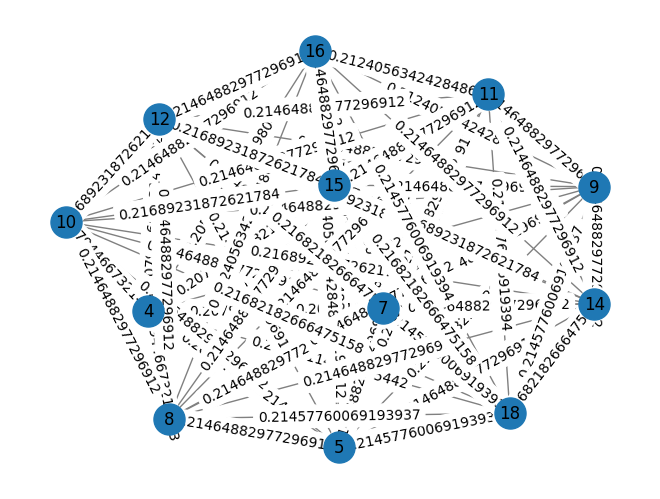

In [62]:
plot_graph(lxl_graph(mpnn_cov[:20])[0])

In [64]:
G, t = lxl_graph(sample_mpnn)
edges = nx.get_edge_attributes(G, 'weight')

In [41]:
def get_edge_weights(G):
    weights = []
    edges = nx.get_edge_attributes(G, 'weight')
    for val in edges.values():
        weights.append(val)
    return weights 

In [ ]:
def degree_histogram(G, G_2=0, G_2_color='blue', title="Degree Histogram"):
    degrees_1 = [G.degree(n) for n in G.nodes()]
    if G_2 != 0:
        degrees_2 = [G_2.degree(n) for n in G_2.nodes()]
        plt.hist([degree/len(degrees_2) for degree in degrees_2], bins=100, align='left', rwidth=0.8, color=G_2_color, alpha=0.7, label='mpnn')
    plt.hist([degree/len(degrees_1) for degree in degrees_1],bins=100,align='left', rwidth=0.8, color='purple', alpha=0.7, label='natural')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(title)
    plt.show()

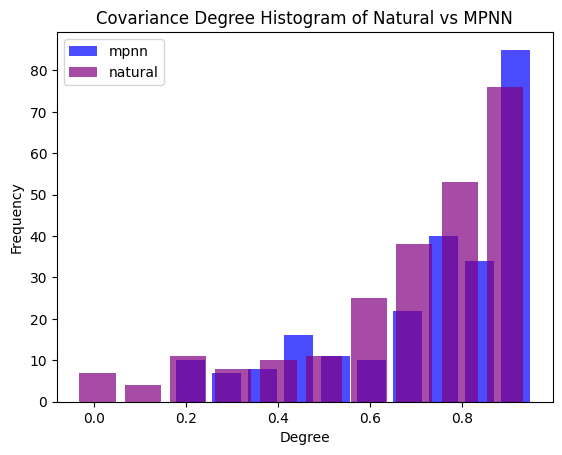

In [105]:
degree_histogram(lxl_graph(nat_cov)[0], lxl_graph(mpnn_cov)[0], title="Covariance Degree Histogram of Natural vs MPNN")

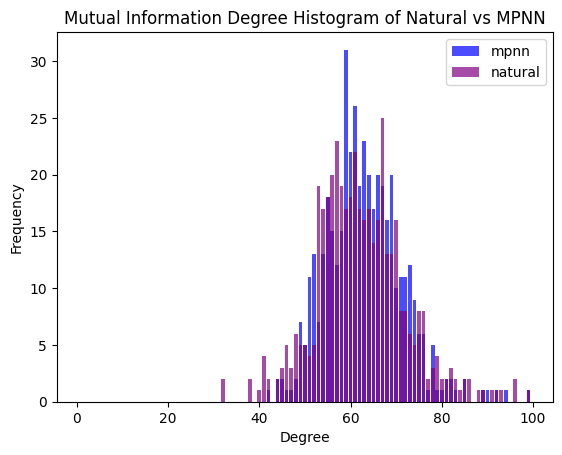

In [89]:
degree_histogram(lxl_graph(mi_nat)[0], lxl_graph(mi_mpnn)[0], title="Mutual Information Degree Histogram of Natural vs MPNN")